# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [3]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets.utils as dataset_utils
from torch.autograd import grad
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torchvision import __version__ as torchvision_version

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# include plots in notebook
%matplotlib inline

In [5]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Tue Nov  8 17:01:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   34C    P0    50W / 350W |      9MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

Colored MNIST dataset already exists


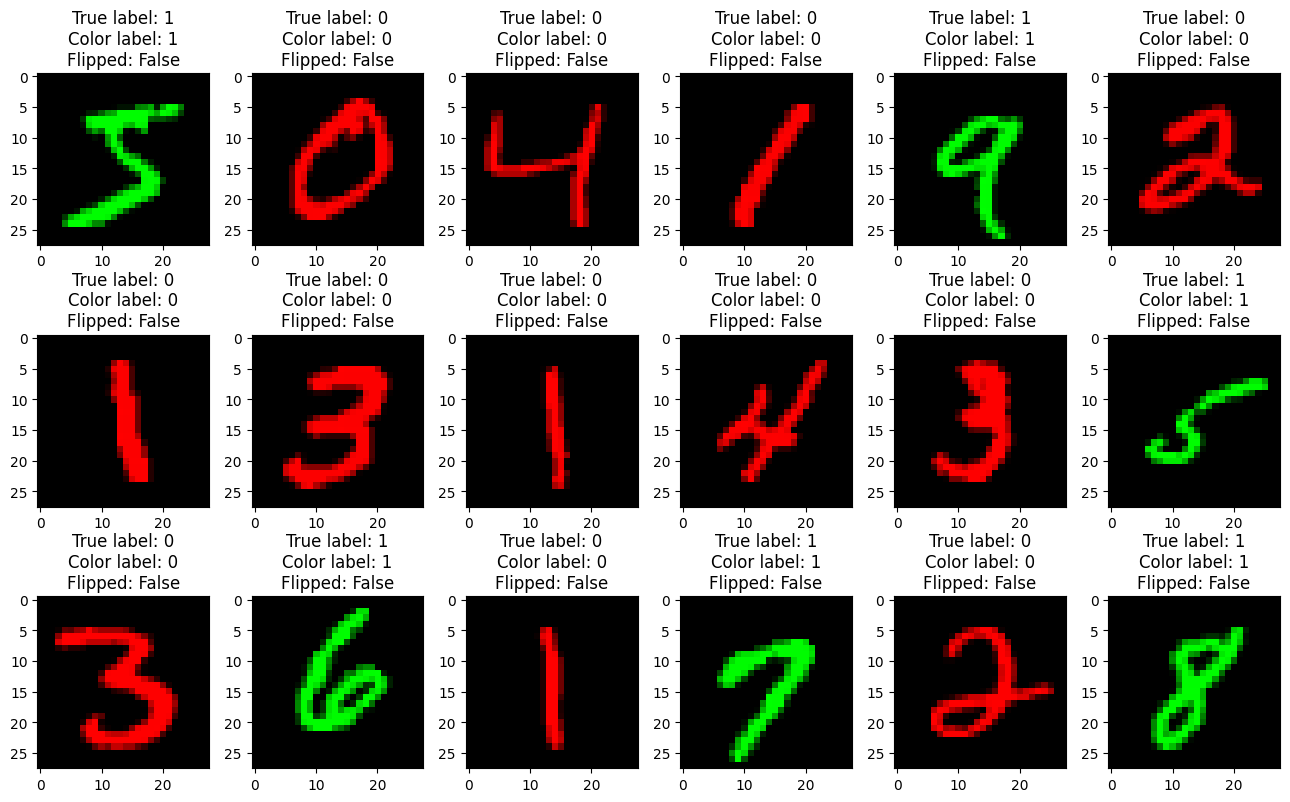

In [6]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

train_set = ColoredMNIST(root='./data',
                          env='train',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            
plot_digits(train_set)

Colored MNIST dataset already exists


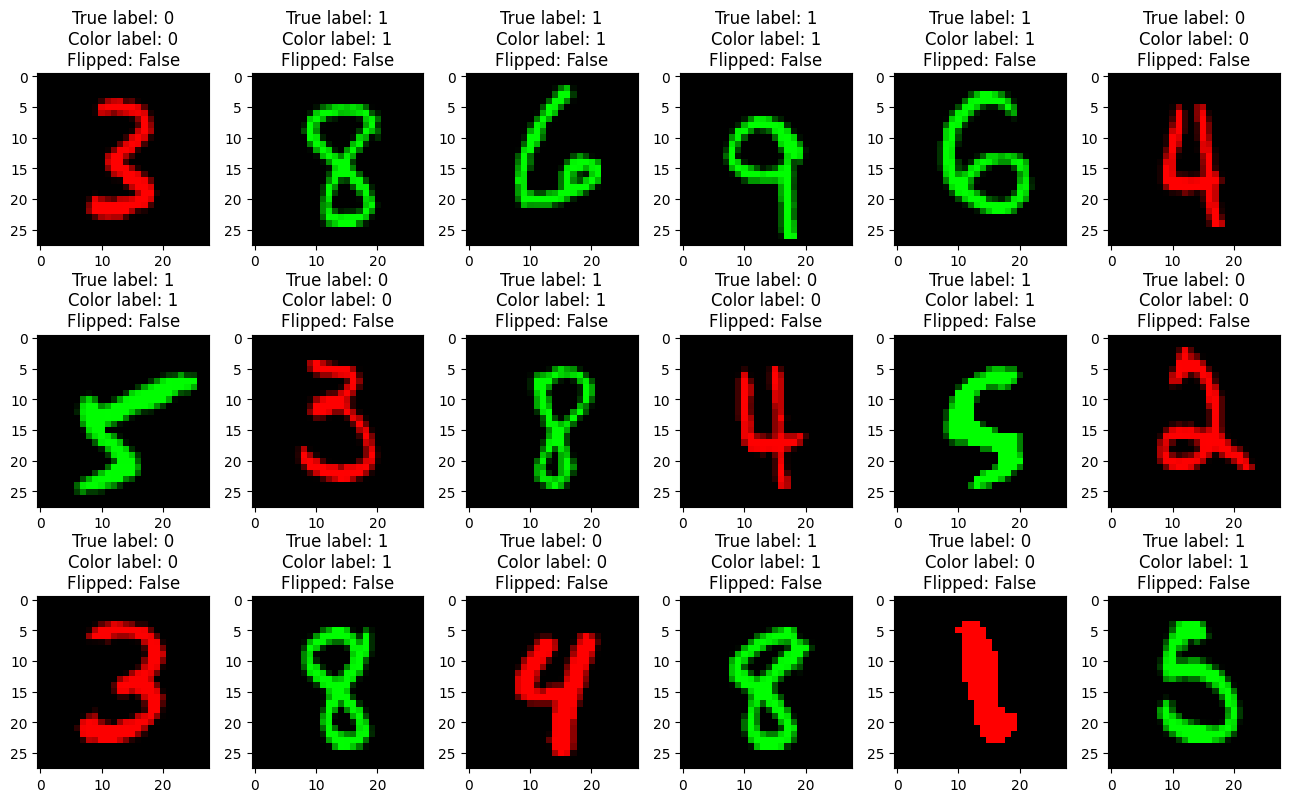

In [7]:
val_set = ColoredMNIST(root='./data',
                          env='val',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            
plot_digits(val_set)

Colored MNIST dataset already exists


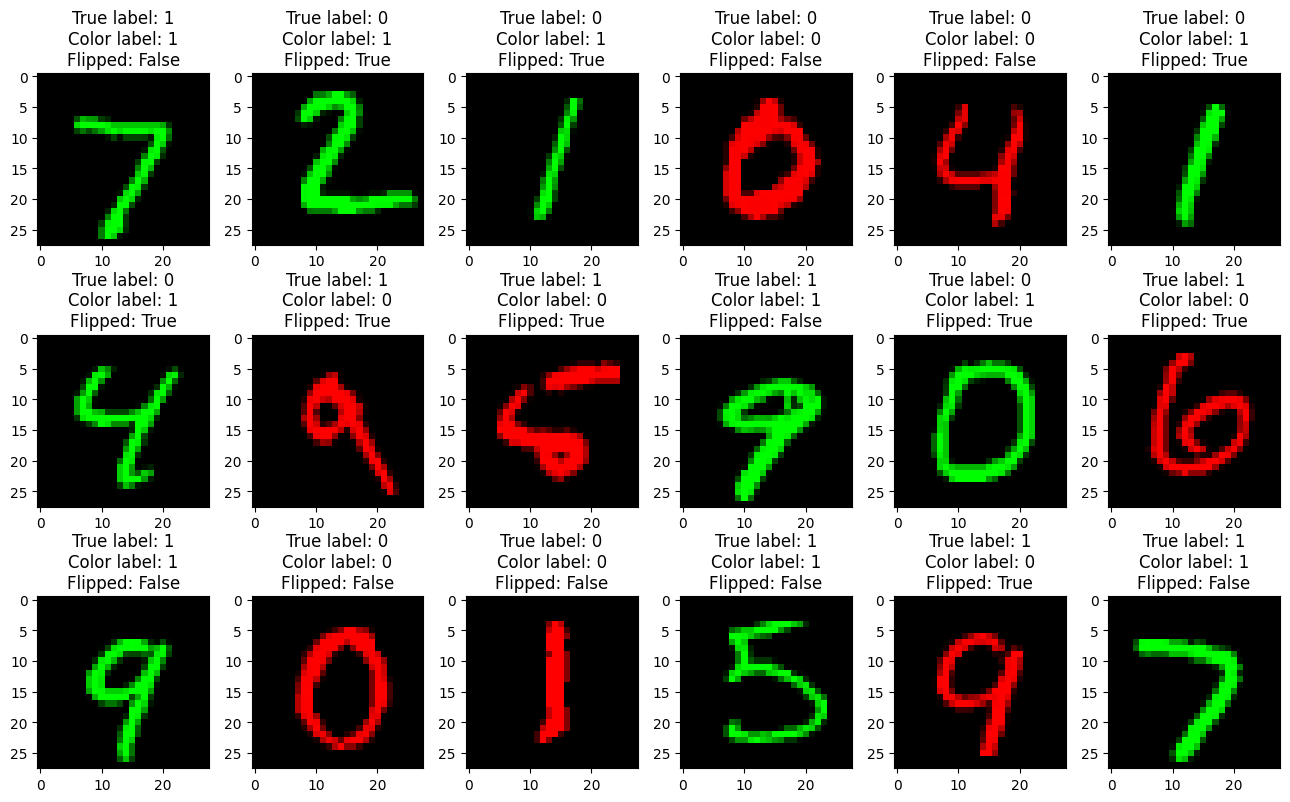

In [8]:
test_set = ColoredMNIST(root='./data',
                          env='test',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            
plot_digits(test_set)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

## Set device (For number crunching)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Initialize network

In [11]:
# Resnet50 transfer learning
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 2)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0160, -0.0121,  0.0184,  ..., -0.0123, -0.0140, -0.0180],
        [-0.0156, -0.0178, -0.0163,  ..., -0.0120,  0.0020, -0.0138]],
       device='cuda:0', requires_grad=True)

## Train network

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   : {'loss' : [],
                                       'acc' : []},
               'train'              : {'loss' : [],
                                       'acc' : []},
                'validation'        : {'loss' : [],
                                       'acc' : []},
                'test'              : {'loss' : [],
                                       'acc' : []}}
        
    # epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # phase
        for phase in ['train_w_backprop', 'train', 'validation', 'test']:
            if phase == 'train_w_backprop':
                model.train()
                datasource = train_loader
            elif phase == "train":
                model.eval()
                datasource = train_loader
            elif phase == "validation":
                model.eval()
                datasource = val_loader
            elif phase == "test":
                model.eval()
                datasource = test_loader
            else:
                raise NotImplementedError("Sorry, unknown phase!")

            epoch_loss = 0.0
            running_corrects = 0
            label_counter = 0

            # mini-batches
            for inputs, _, low_high_lables, _ in datasource:
                inputs = inputs.to(device)
                low_high_lables = low_high_lables.to(device)
                
                logits = model(inputs)
                preds = logits.argmax(dim=1)
                running_corrects += torch.sum(preds == low_high_lables.data)
                label_counter += low_high_lables.size()[0]
                
                batch_loss = criterion(logits, low_high_lables)
                epoch_loss += batch_loss.item()

                if phase == 'train_w_backprop':
                    optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                    batch_loss.backward()   # compute gradients
                    optimizer.step()        # Performs a single optimization step (parameter update).
                
            epoch_acc = 100 * running_corrects.double() / label_counter
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.cpu())
            
    return model, history, inputs, low_high_lables, logits, batch_loss, label_counter

In [13]:
# F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
# https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
#criterion = F.binary_cross_entropy_with_logits #(input, target)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)

In [14]:
model, history, inputs, labels, preds, batch_loss, label_counter = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
train_w_backprop loss: 89.8659, acc: 95.5560
train loss: 39.9594, acc: 99.0300
validation loss: 7.5726, acc: 99.0900
test loss: 120.7208, acc: 49.9800
Epoch 2/50
----------
train_w_backprop loss: 30.3794, acc: 99.1080
train loss: 22.8296, acc: 99.3860
validation loss: 4.3067, acc: 99.4300
test loss: 155.4395, acc: 50.1600
Epoch 3/50
----------
train_w_backprop loss: 19.7732, acc: 99.3180
train loss: 16.1033, acc: 99.4920
validation loss: 2.9994, acc: 99.5100
test loss: 183.1046, acc: 50.1000
Epoch 4/50
----------
train_w_backprop loss: 15.0595, acc: 99.4400
train loss: 12.9436, acc: 99.5260
validation loss: 2.4125, acc: 99.5800
test loss: 201.2794, acc: 50.2200
Epoch 5/50
----------
train_w_backprop loss: 12.2677, acc: 99.4760
train loss: 10.1813, acc: 99.6440
validation loss: 1.8970, acc: 99.6600
test loss: 220.3408, acc: 49.8800
Epoch 6/50
----------
train_w_backprop loss: 10.4736, acc: 99.5200
train loss: 9.3880, acc: 99.6220
validation loss: 1.8282, acc: 99.63

## Assess performance

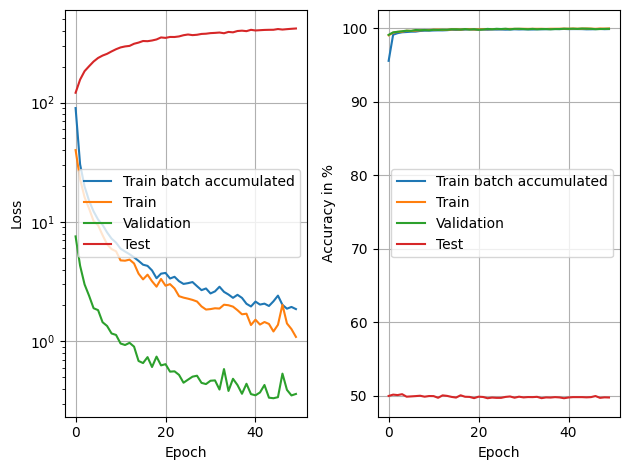

In [15]:
def plot_history(hist, show_curves=['train_w_backprop', 'train', 'validation', 'test']):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    if 'train_w_backprop' in show_curves:
        plt.semilogy(range(len(hist['train_w_backprop']['loss'])), hist['train_w_backprop']['loss'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.semilogy(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    if 'validation' in show_curves:
        plt.semilogy(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    if 'test' in show_curves:
        plt.semilogy(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    if 'train_w_backprop' in show_curves:
        plt.plot(range(len(hist['train_w_backprop']['acc'])), hist['train_w_backprop']['acc'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    if 'validation' in show_curves:
        plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    if 'test' in show_curves:
        plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_history(history, show_curves=['train_w_backprop', 'train', 'validation', 'test'])

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this resnet50:  
Most probably, the training (50000 samples) and the validation (5000 samples) datasets are not 100% i.i.d. from the same distribution (or at least they are unbalanced!) and there are some less complicated samples in the smaller dataset. This usually is the case, if the validation loss is smaller than the training loss. This hypothesis needs to be proven! This can be confirmed in a simple and easy way by switching the training and the validation (5000 samples) dataset and validate on the training (50000 samples) dataset. In this case the training loss curve (obtained with the validation dataset) is lower than the validation loss curve (obtained with the training dataset)! Of course, this is not a 100% perfect proof, but a simple and easy indicator to support this hypothesis. If this should be a problem, more analysis of the data needs to be done.

Batch accuracy: 100.0%


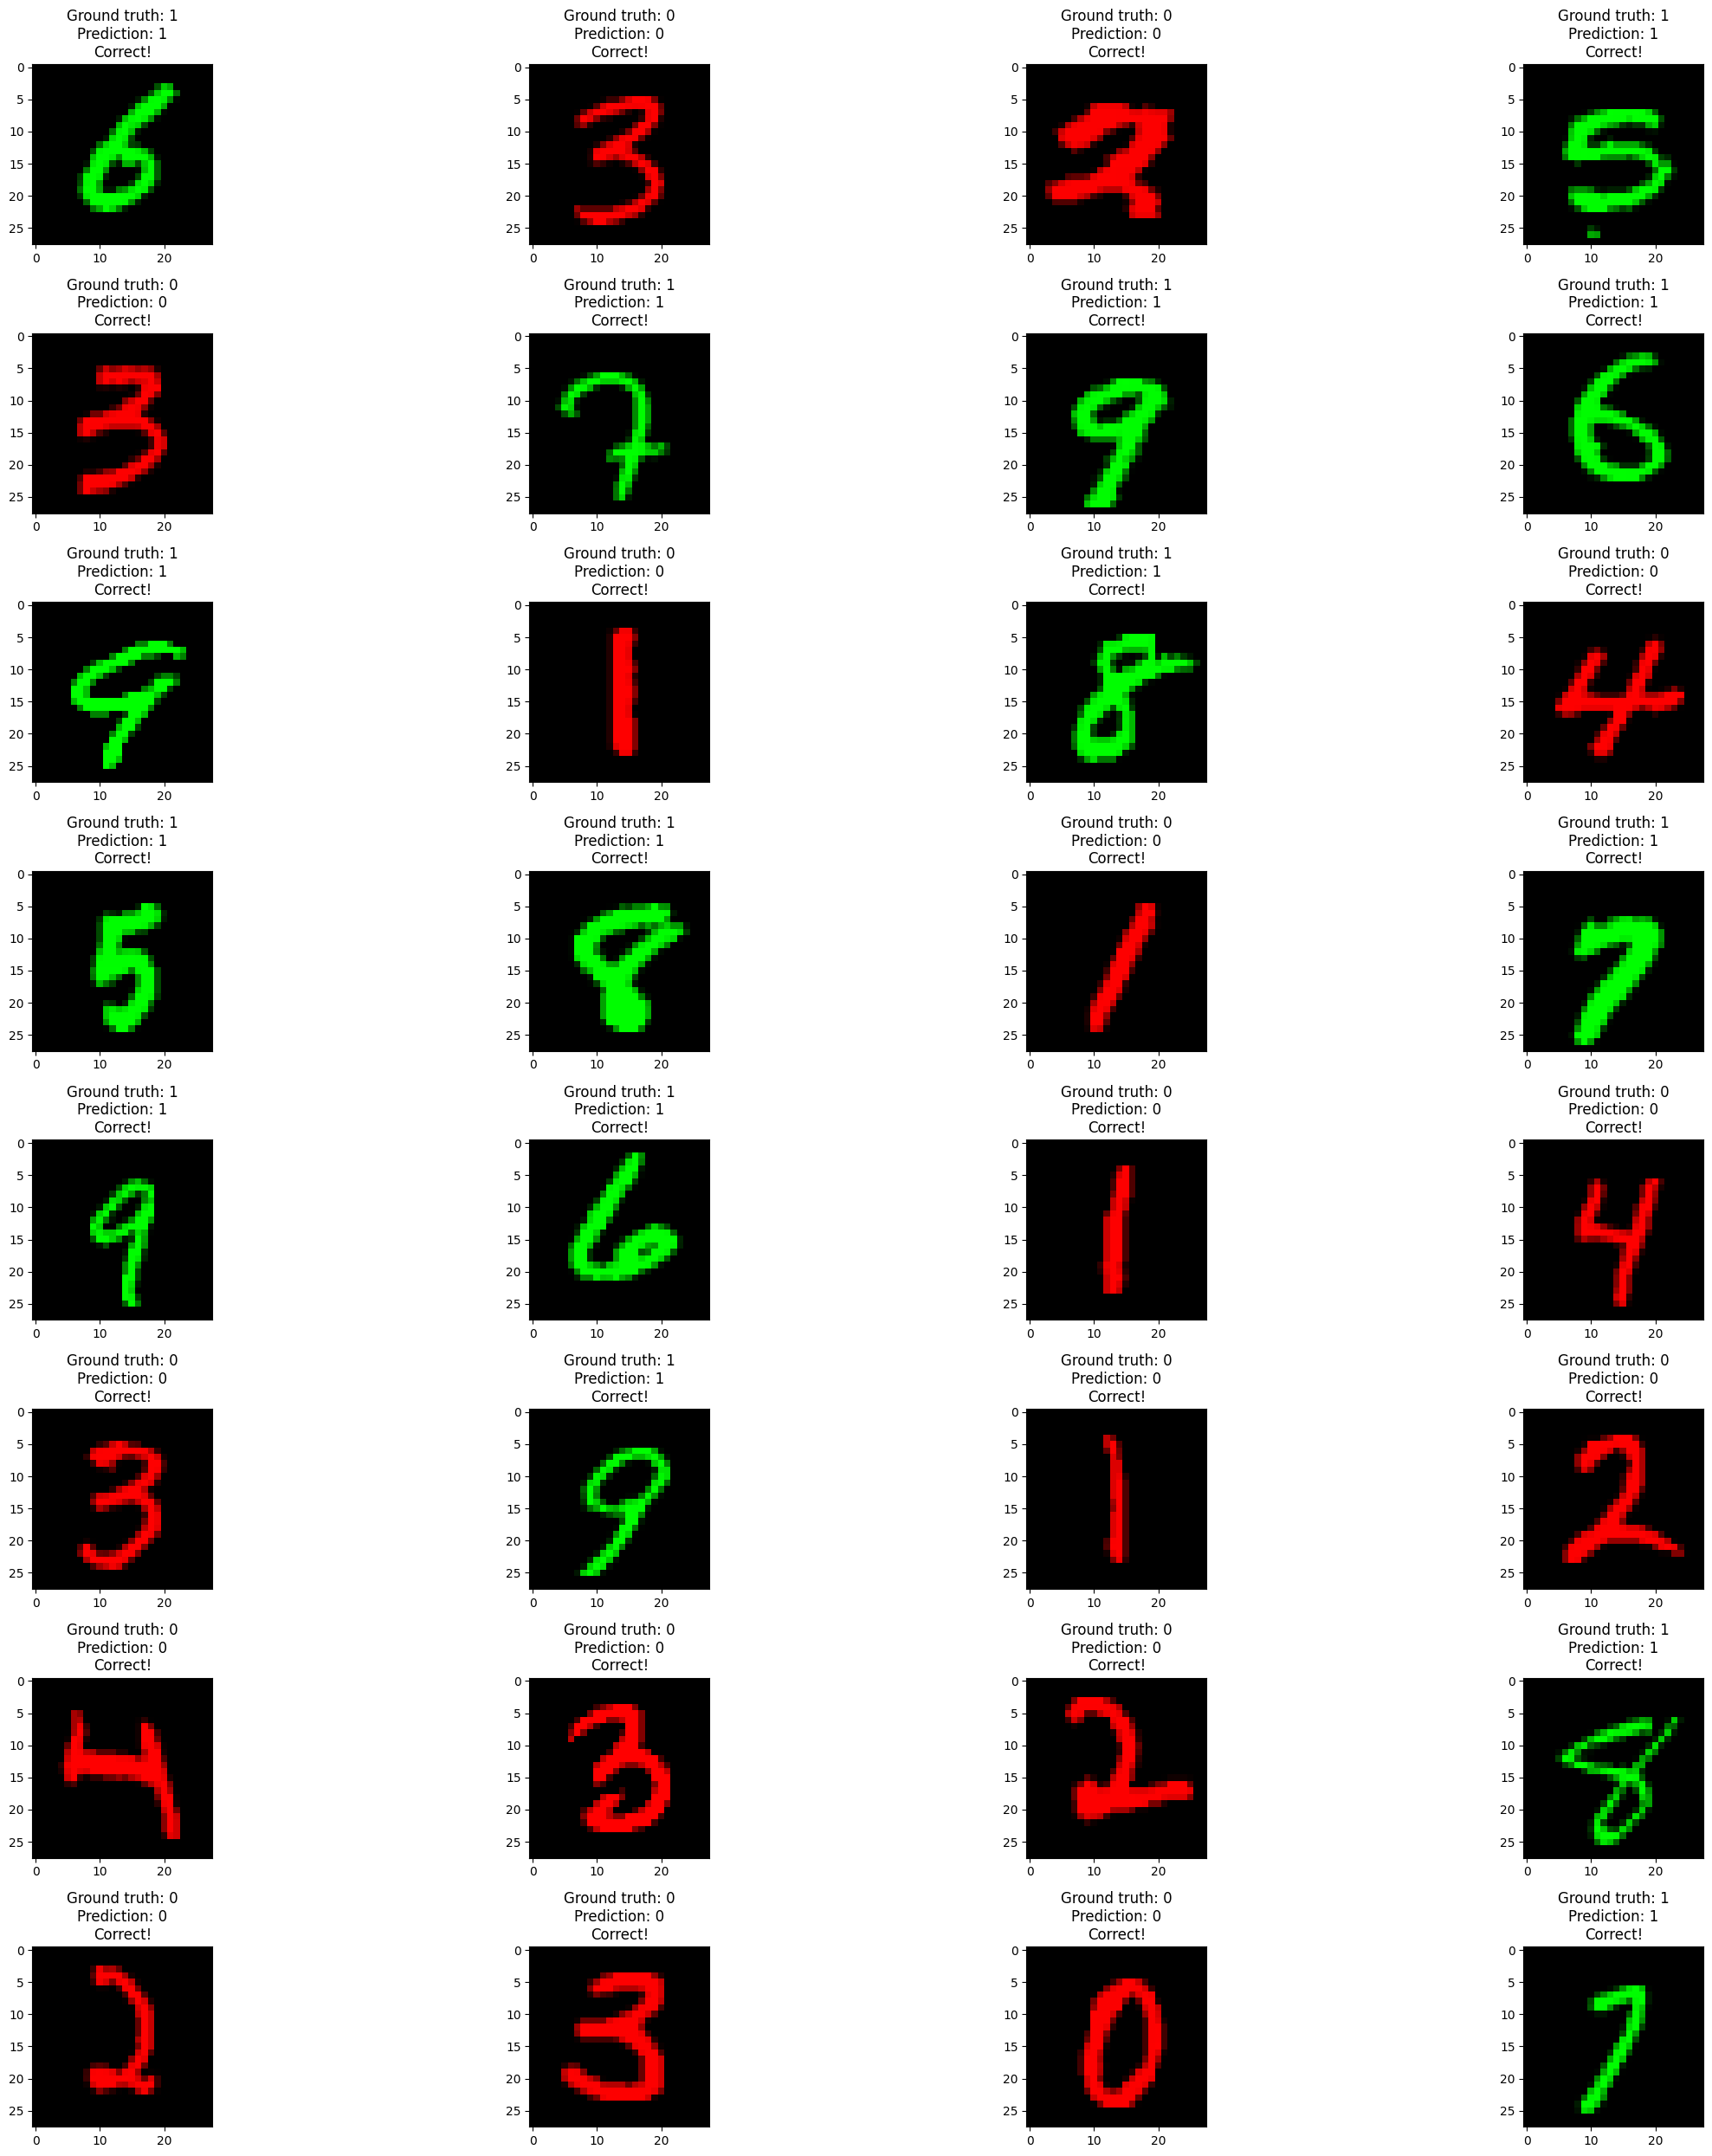

In [16]:
random_tests(train_loader, model, device)

Batch accuracy: 100.0%


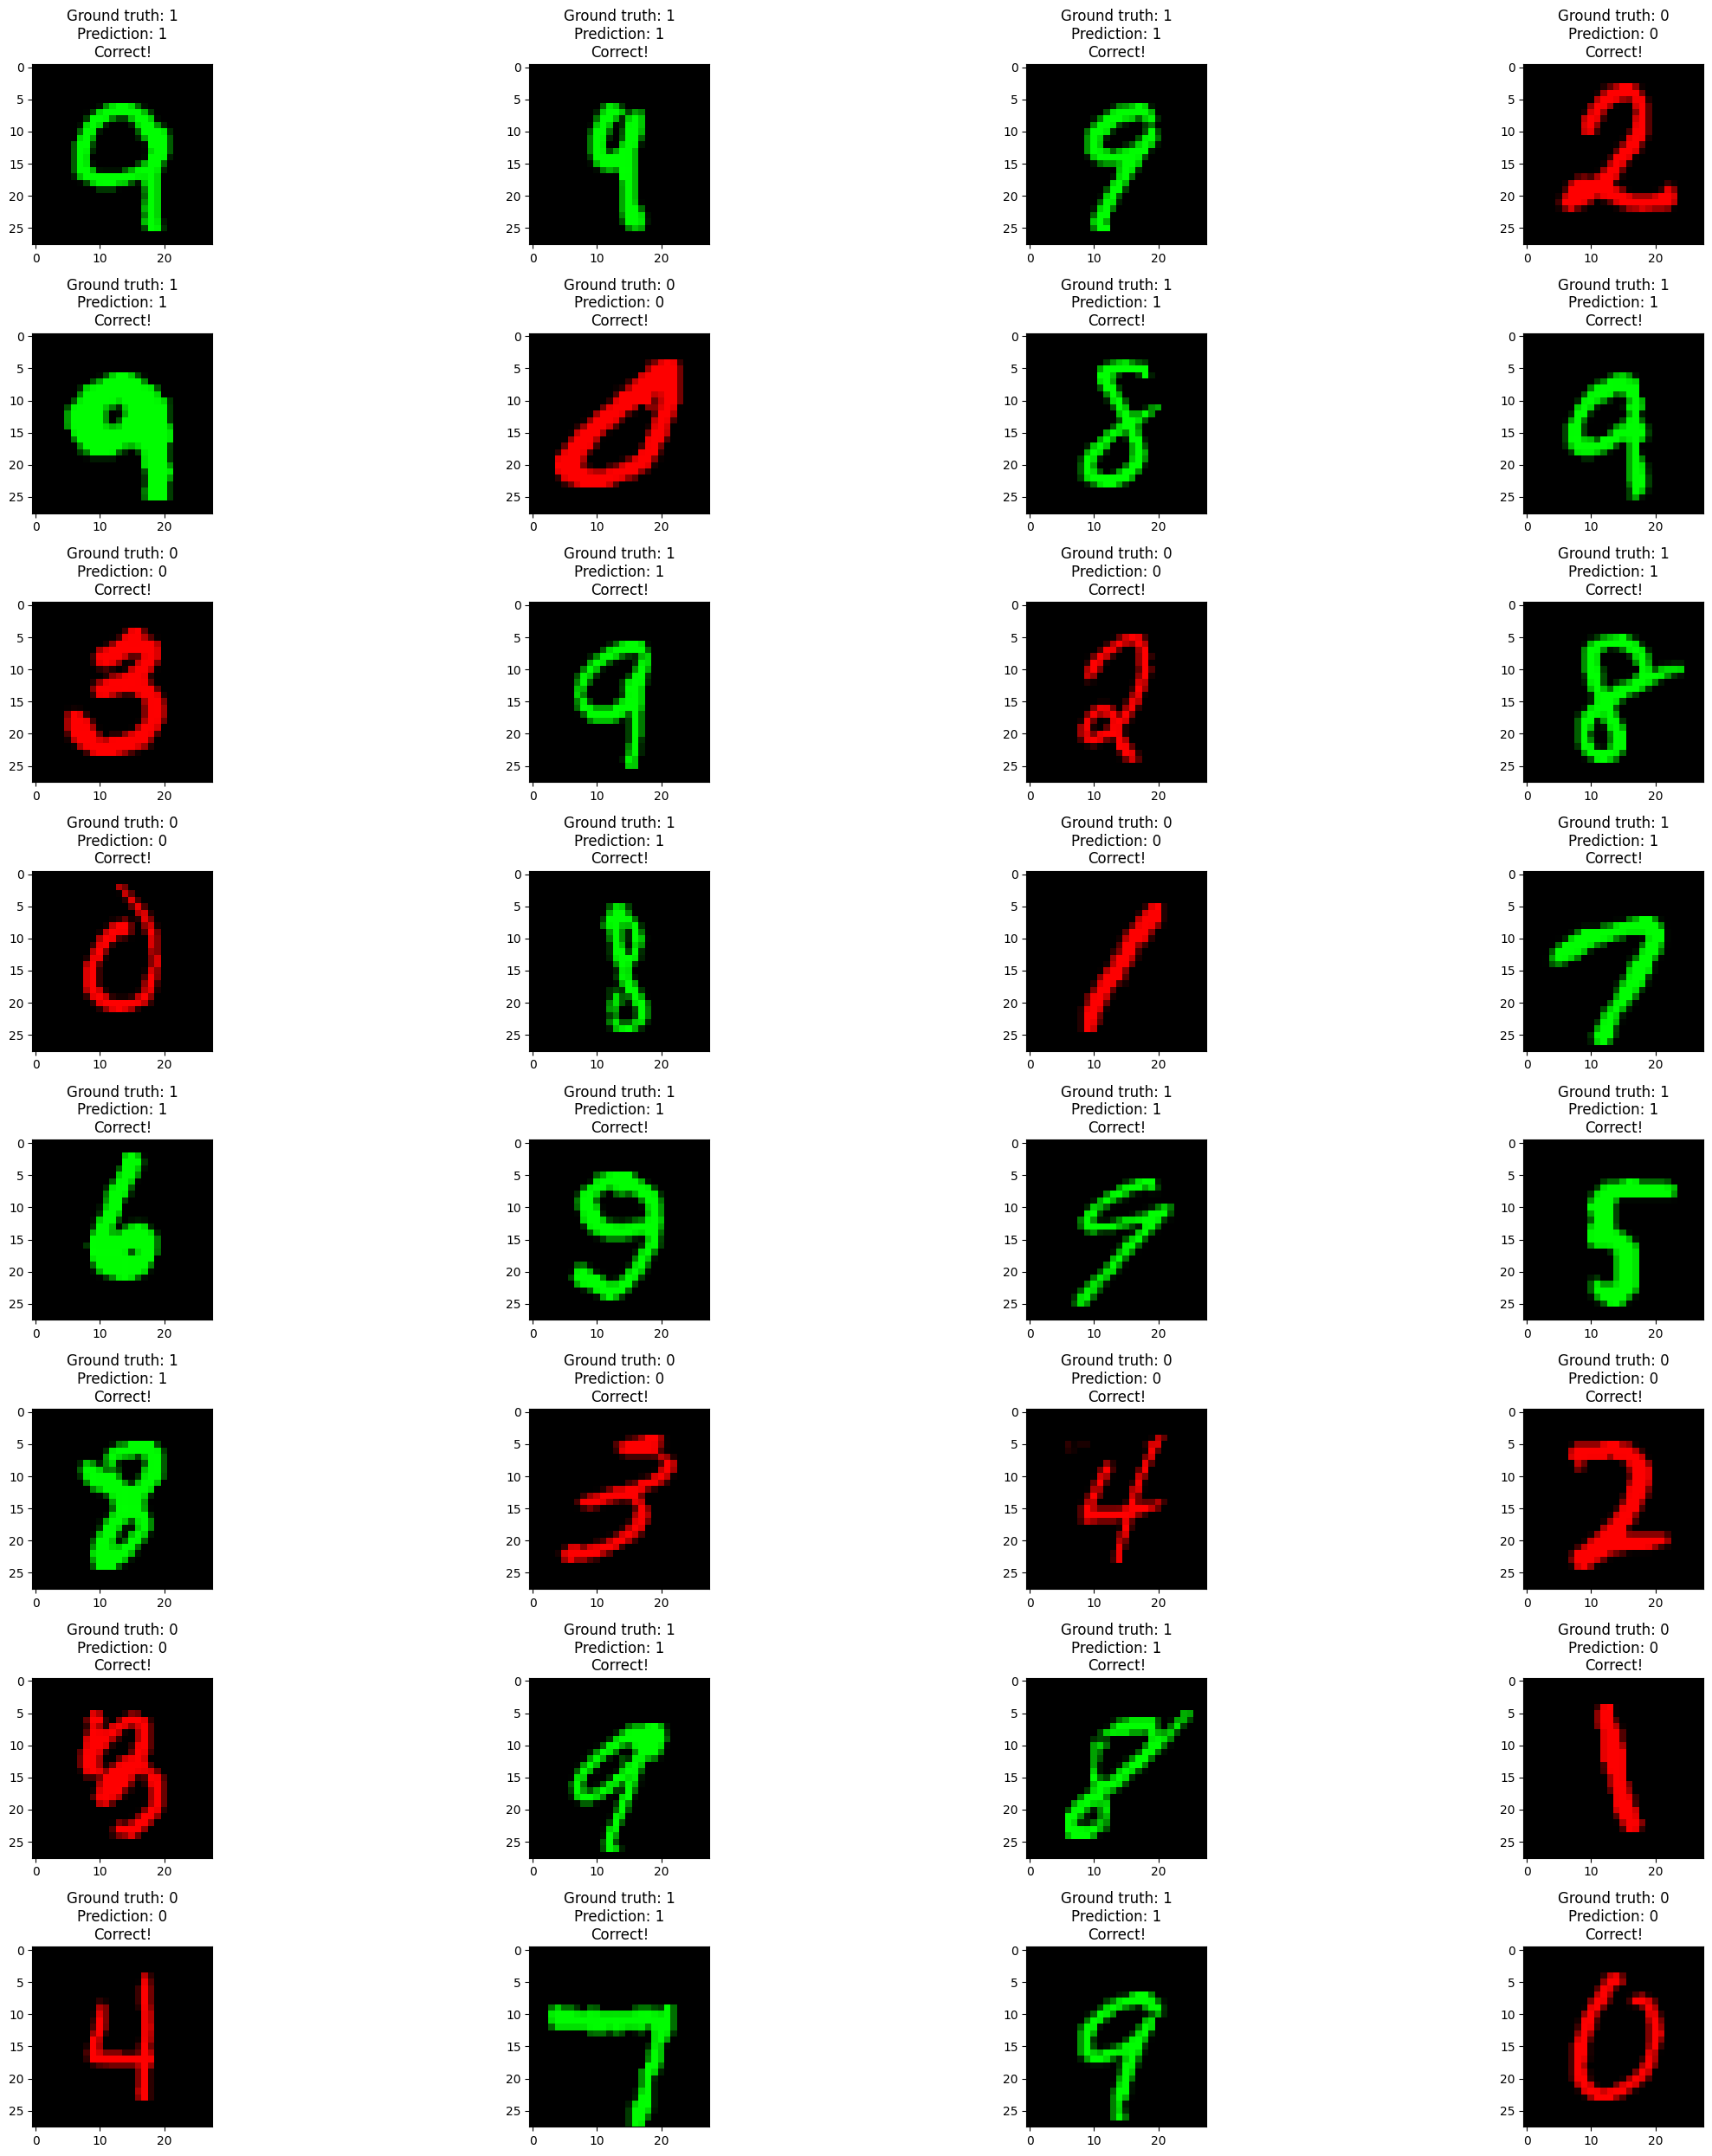

In [17]:
random_tests(val_loader, model, device)

Batch accuracy: 53.90625%


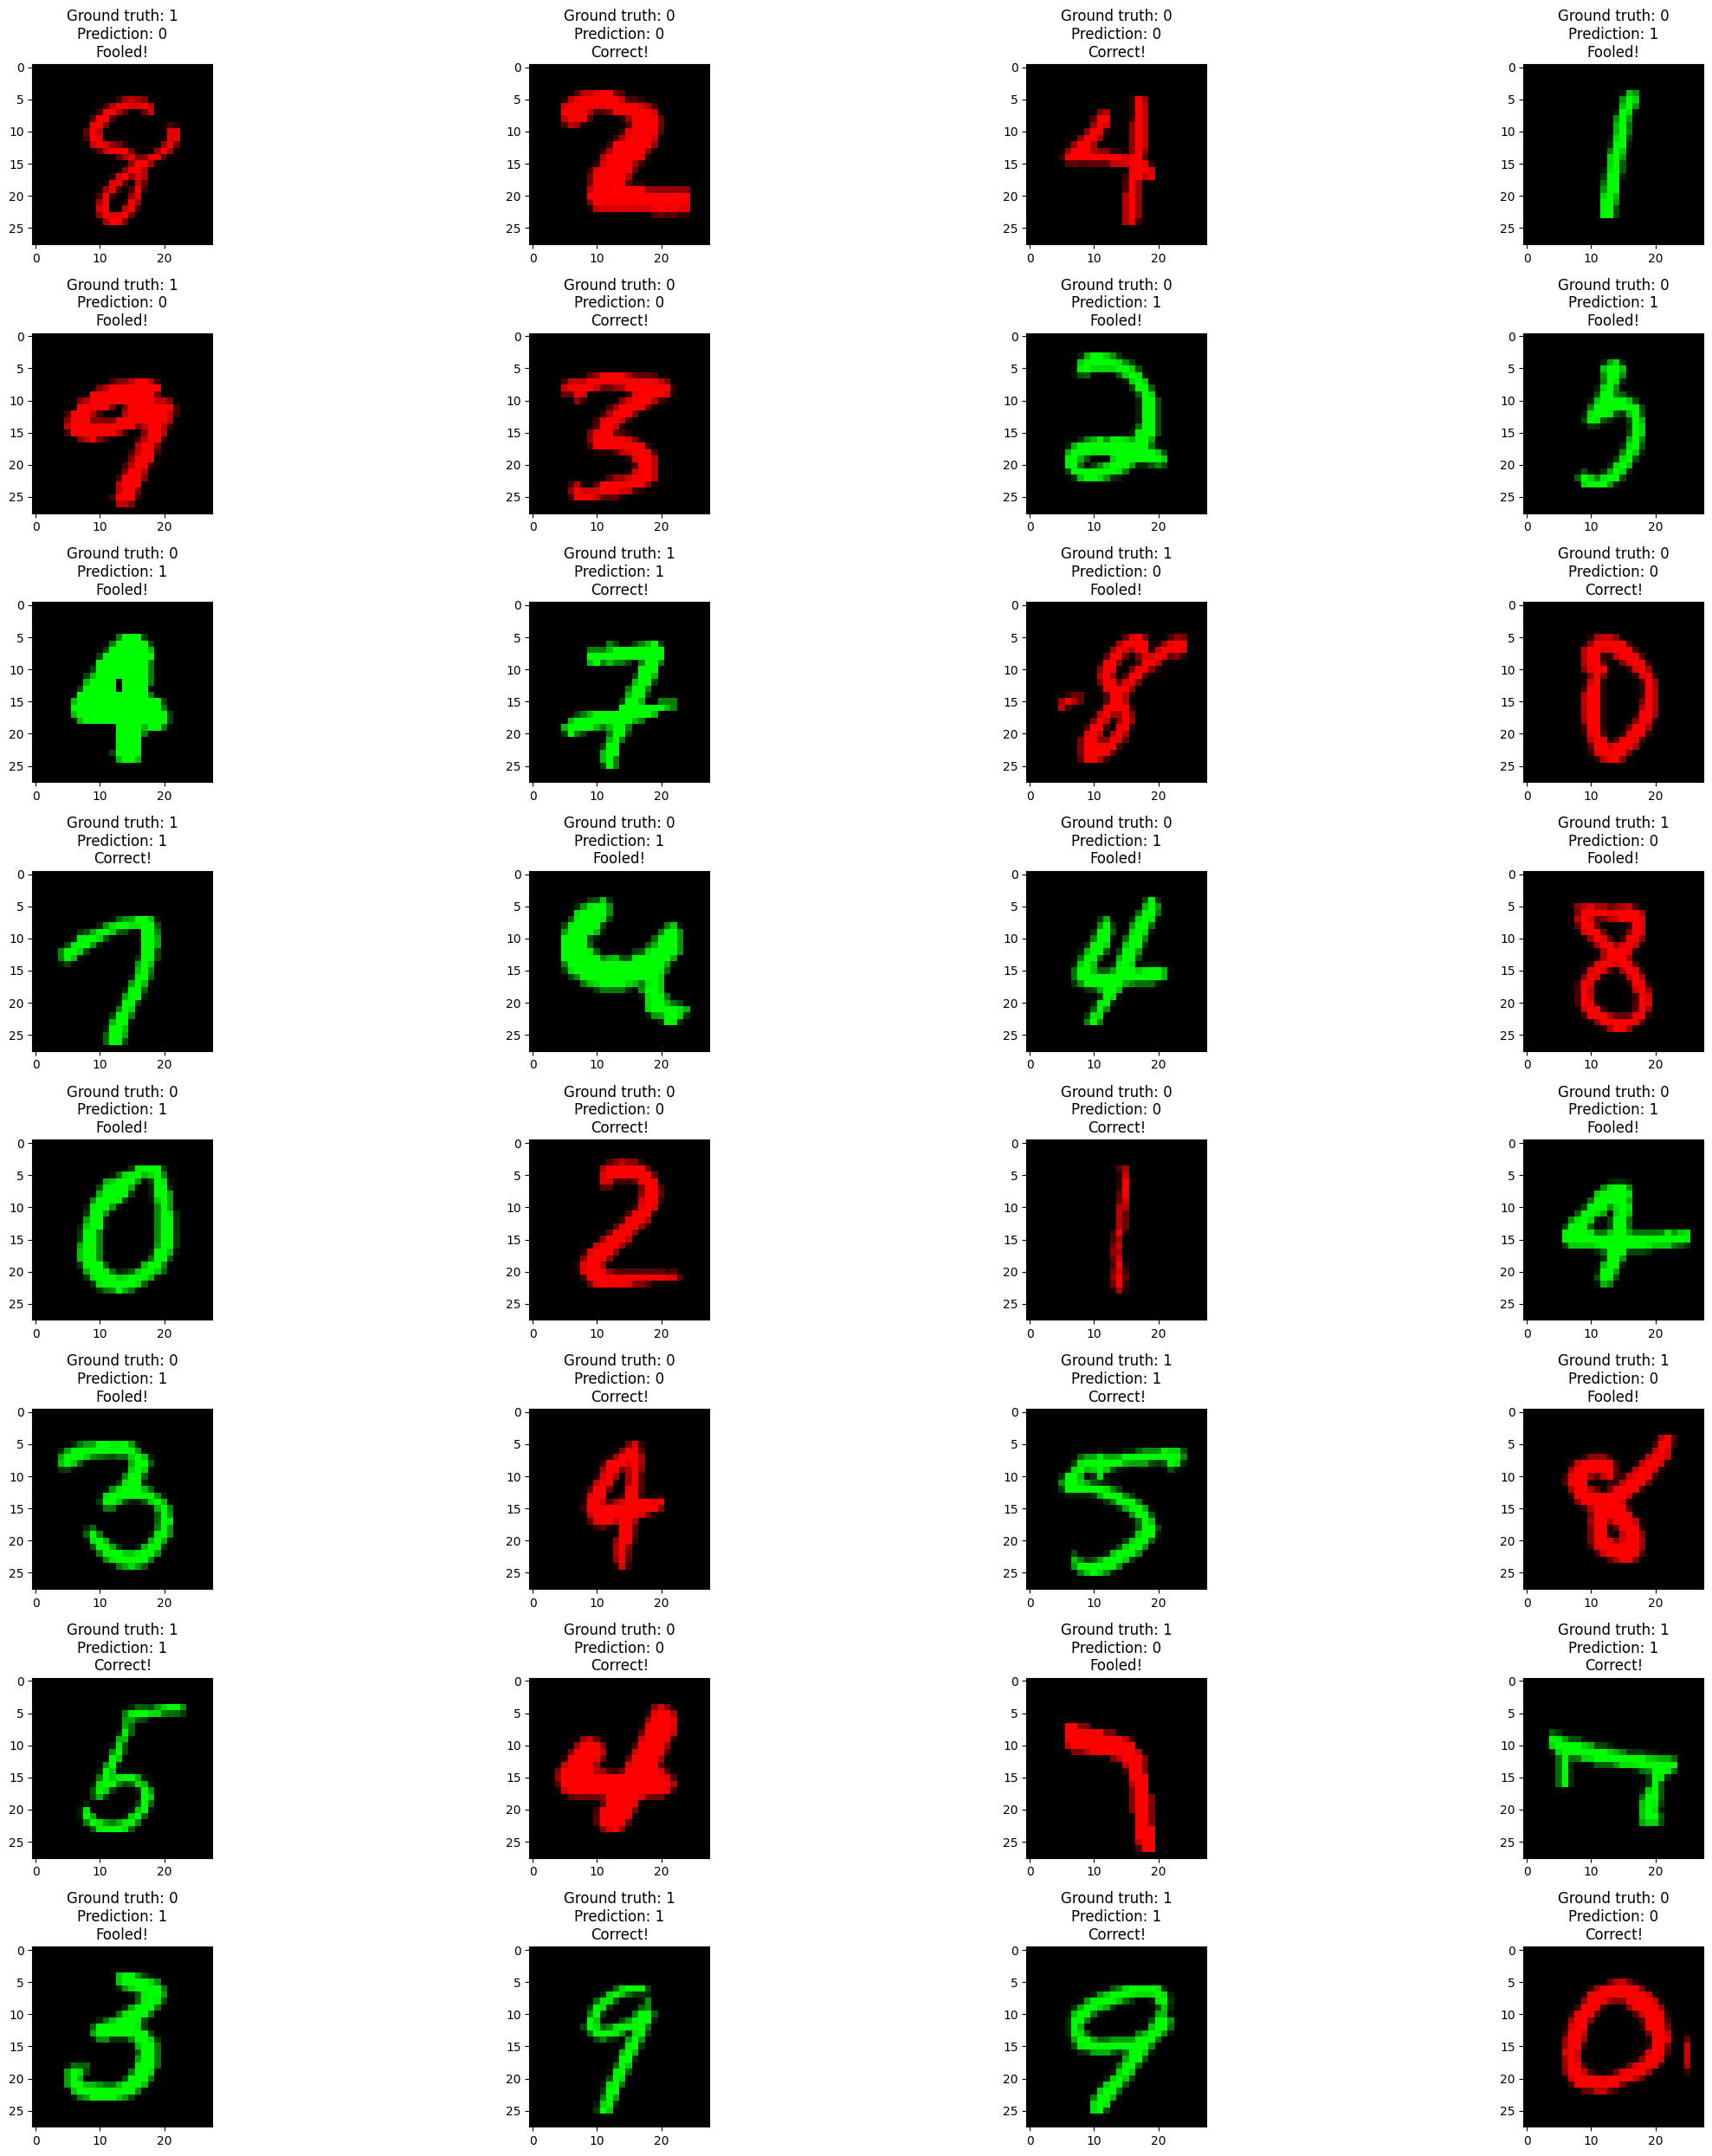

In [18]:
random_tests(test_loader, model, device)